We have 100 training observations and 1000 prediction observations
RMSE for OLS with mean replacement of NaN = 0.958083266107
The optimal RMSE for ridge is with lambda = 4.0404040404 and has RMSE of 0.42065611971


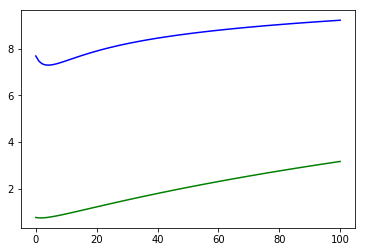

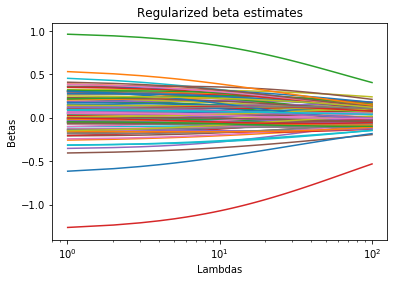

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Text(0,0.5,'Nr of variables')

In [38]:
#!/usr/bin/env python2
# -*- coding: utf-8 -*-
"""
Created on Thu Mar  8 13:35:03 2018

@author: wisse
"""



import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, ElasticNet
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from preprocessing import oneOutOfK, missing_predictor_as_mean, missing_predictor_as_value, missing_predictor_as_knn
from sklearn.model_selection import KFold
import scipy.linalg as lng
from helpers import RMSE, center, normalize, normalizetest 



# load and display data
data = pd.read_csv('Case1_Data.csv')
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

# split data in training / prediction based of Y value
training = data.loc[data['Y'].notnull()]
prediction = data.loc[data['Y'].isnull()]

print ('We have', len(training), 'training observations and', 
       len(prediction), 'prediction observations')

train_y = training['Y'].values
train_X = training[[col for col in training.columns if col != 'Y']].values


# One out of K encoding for categorical value
train_X = oneOutOfK(train_X, 99).astype(float)

# Flag for what handling of missing values to use
KNN_rpl = False


# replace missing values with mean of column
train_X_mn = missing_predictor_as_mean(train_X)

# replace missing values with mean of KNN
clean_data = missing_predictor_as_value(train_X, 0)
train_X_knn = missing_predictor_as_knn(5, train_X, clean_data)

# split Train / Test (70% / 30%) (for train_X)
test_split_ratio = 0.3

if (KNN_rpl):
    X_train, X_test, y_train , y_test= train_test_split(train_X_knn, train_y, test_size=test_split_ratio, random_state=0)
else:
    X_train, X_test, y_train , y_test= train_test_split(train_X_mn, train_y, test_size=test_split_ratio, random_state=0)


# First, we'll establish a baseline for the prediction with OLS 
# on the data with NaN's replaced with the column's mean
 # Linear solver
[n_train, p_train], [n_test, p_test] = np.shape(X_train), np.shape(X_test)

 
off_train, off_test = np.ones(n_train), np.ones(n_test)
M_train, M_test = np.c_[off_train, X_train], np.c_[off_test, X_test] # Include offset / intercept
beta, res, rnk, s = lng.lstsq(M_train, y_train)
yhat = np.matmul(M_test, beta)

#residuals
res = (y_test - yhat) ** 2


print('RMSE for OLS with {} replacement of NaN ='.format('knn' if KNN_rpl else 'mean'),  RMSE(y_test, yhat))

K = 2

# K - fold cross validation 
kf = KFold(K, shuffle=True)

ols_mse = np.ones((K))

for i, (train_index, test_index) in enumerate(kf.split(X_train)):
    # use _train_cv for the created subset of train and _val for the cv test
    # print("TRAIN CV:", len(train_index), "VAL:", len(test_index))
    X_train_cv, X_val = X_train[train_index], X_train[test_index]
    y_train_cv, y_val = y_train[train_index], y_train[test_index]
    [n_train_cv, p_train_cv], [n_val, p_val] = np.shape(X_train_cv), np.shape(X_val)
    
    # include intercept
    off_train_cv, off_val = np.ones(n_train_cv), np.ones(n_val)
    M_train_cv, M_val = np.c_[off_train_cv, X_train_cv], np.c_[off_val, X_val] # Include offset / intercept


# Ridge regression with k-fold cross validation

n, p = X_train.shape

k = 100; # try k values of lambda
lambdas = np.linspace(0, 100, k)

# Number of folds
K = 10   

betas = np.zeros((K, p, k)) # all variable estimates
training_error = np.zeros((K, k))
testing_error =  np.zeros((K, k))
MSE = np.zeros((K, k))
RMSE_ridge = np.zeros((K, k))

# Actual manual failing cross-validation

kf = KFold(10)
#kf.get_n_splits(X_train)

for i, (train_index, test_index) in enumerate(kf.split(X_train)):
    # use _train_cv for the created subset of train and _val for the cv test
    # print("TRAIN CV:", len(train_index), "VAL:", len(test_index))
    X_train_cv, X_val = X_train[train_index], X_train[test_index]
    y_train_cv, y_val = y_train[train_index], y_train[test_index]
    
    for j in range(0, len(lambdas)):
        # Make the ridge model
        ridge = Ridge(alpha=lambdas[j], fit_intercept=False)
        
        # Fit ridge
        ridge.fit(X_train_cv, y_train_cv)
        beta = ridge.coef_
        betas[(i-1), : , j] = beta
        y_hat_val = np.matmul(X_val, beta)
        y_hat_train = np.matmul(X_train, beta)

        MSE[(i-1), j ] = np.mean((y_val - y_hat_val)**2)
        RMSE_ridge[(i-1), j ] = RMSE(y_val, y_hat_val)
        training_error[(i-1), j ] = np.mean((y_train - y_hat_train)**2)
        testing_error[(i-1), j ] = np.mean((y_val - y_hat_val)**2)
 


mean_test_error = np.mean(testing_error, axis=0)
mean_training_error = np.mean(training_error, axis=0)

meanMSE = np.mean(MSE, axis = 0)
jOpt = np.argsort(meanMSE)[0]
lambda_OP = lambdas[jOpt]

meanRMSE = np.mean(RMSE_ridge, axis = 0)
jOpt_rmse = np.argsort(meanRMSE)[0]


lambda_OP = lambdas[jOpt]
lambda_OP_RMSE = lambdas[jOpt_rmse]

print('The optimal RMSE for ridge is with lambda =', lambda_OP_RMSE, 'and has RMSE of', np.min(RMSE_ridge))
plt.plot(lambdas, mean_training_error, color="green")
plt.plot(lambdas, mean_test_error, color="blue")
plt.show()

# average betas over 10 folds
mean_betas = np.mean(betas, axis=0)

plt.figure()
plt.semilogx(lambdas, mean_betas.T )
plt.xlabel("Lambdas")
plt.ylabel("Betas")
plt.title("Regularized beta estimates")
plt.show()

# elastic net

# alphas = range(0,11,1) # Ratio between L1 and L2 norms
ratios = range(0,11,1)
lambdas_EN = np.linspace(0.001, 100, k)

training_error_EN = np.zeros((K, k, len(ratios)))
testing_error_EN = np.zeros((K, k, len(ratios)))
K_elasticNet = np.empty((K, k, len(ratios)))



RMSE_EN = np.zeros((K, k, len(ratios)))



for i, (train_index, test_index) in enumerate(kf.split(X_train)):
    X_train_cv, X_val = X_train[train_index], X_train[test_index]
    y_train_cv, y_val = y_train[train_index], y_train[test_index]
    
    y_train_cv, my = center(y_train_cv) # center training response
    y_val = y_val - my # use the mean value of the traininag response to center the test response
    X_train_cv = X_train_cv.astype(float)
    X_val = X_val.astype(float)
    X_tain_cv, mx, varx = normalize(X_train_cv) # normalize training data
    X_val = normalizetest(X_val, mx, varx)
    for k, l in enumerate(lambdas_EN):
        for j, ratio in enumerate(ratios):
            regr = ElasticNet(alpha=l, l1_ratio=ratio / 10, fit_intercept=False)
            regr.fit(X_train_cv, y_train_cv)
            beta = regr.coef_
    
            y_hat_val = np.matmul(X_val, beta)
            y_hat_train = np.matmul(X_train, beta)  
            
            RMSE_EN[(i-1), k, j] = RMSE(y_val, y_hat_val)
            training_error_EN[(i-1), k, j ] = np.mean((y_train - y_hat_train)**2)
            testing_error_EN[(i-1), k, j ] = np.mean((y_val - y_hat_val)**2)
            K_elasticNet[i-1, k, j] = len(np.where(beta != 0)[0])

err_trEN = np.mean(training_error_EN,0) # Mean across bootstrap samples
err_tstEN = np.mean(testing_error_EN,0)
K_nonzEN = np.mean(K_elasticNet,0)


#%% error development when going from ridge to lasso, training, 0.5 ratio corrosponse to elastic net
lambda_leg = ["Lambda %0.3f" % lambdas[0], "Lambda %0.3f" % lambdas[1], "Lambda %i" % lambdas[2], "Lambda %i" % lambdas[3]]
titles = ["Train", "Test", "Nr of vars"]
fig, ax = plt.subplots(1,3)
ax[0].plot(err_trEN.T)
ax[1].plot(err_tstEN.T)
ax[2].plot(K_nonzEN.T)

for i in range(3):
    ax[i].set_xlabel("L1/L2 Ratio (Lasso to Ridge)")
    ax[i].set_ylabel("Error")
    ax[i].xaxis.set_ticks(np.arange(0,11))
    labels = [item.get_text() for item in ax[0].get_xticklabels()]
    for k in range(K):
        labels[k] = str(k/10)
    ax[i].set_xticklabels(labels)
    ax[i].set_title(titles[i])
ax[2].set_ylabel("Nr of variables")

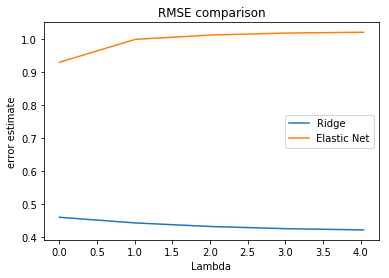

In [35]:
# Formatting Elastic Net RMSE error to be plotable
plt.figure(1)
RMSE_EN_plot = np.mean(RMSE_EN,0)
RMSE_EN_plot = np.mean(RMSE_EN_plot,1)
ridge_RMSE_plot = plt.plot(lambdas[0:5], RMSE_ridge[1][0:5], label='Ridge')
elasticNet_RMSE_plot = plt.plot(lambdas[0:5], RMSE_EN_plot[0:5], label='Elastic Net')

plt.xlabel('Lambda')
plt.ylabel('error estimate')
plt.title("RMSE comparison")
plt.legend(['Ridge', 'Elastic Net'])


plt.show()

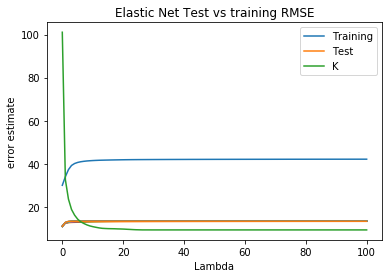

In [37]:
# Elastic net plot
plt.figure(2)
plotting_training_error = np.mean(err_trEN,1)
plotting_test_error = np.mean(err_tstEN,1)
plotting_k = np.mean(K_nonzEN,1)
training_error_plot = plt.plot(lambdas, plotting_training_error, label='Training')
test_error_plot = plt.plot(lambdas, err_tstEN, label='Test')
K_non_zero_plot = plt.plot(lambdas, plotting_k, label='K')

plt.xlabel('Lambda')
plt.ylabel('error estimate')
plt.title("Elastic Net Test vs training RMSE")
plt.legend(['Training', 'Test', 'K'])


plt.show()